# 代码实现


我们将通过编程实现SIFT算法。将SIFT的每一步流程都编写成一个函数。首先，我们来实现尺度空间的生成。

In [1]:
import cv2
import numpy as np
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
import random


# 生成指定数目的高斯核，并对图像做高斯滤波
def generateGimage(image, sigma, num_layers = 8, k_stride = 2):
    sigma_res = np.sqrt(np.max([(sigma ** 2) - ((1) ** 2), 0.01]))
    # (0,0)表示卷积核的大小根据sigma来决定
    image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_res, 
                             sigmaY=sigma_res)
    
    # 生成高斯核
    k = 2 ** (1 / k_stride)
    gaussian_kernels = np.zeros(num_layers)
    # 第一层高斯就是1.6
    gaussian_kernels[0] = sigma
    
    for i in range(1, num_layers):
        # 根据高斯的性质，可以将大的高斯核拆分，减少计算量
        gaussian_old = k**(i-1) * sigma
        gaussian_new = k * gaussian_old
        gaussian_kernels[i] = np.sqrt(gaussian_new**2 - gaussian_old**2)
    
    # 至此，我们已经得到一系列高斯核
    
    # 进行高斯模糊
    gaussian_images = [image]
    for kernel in gaussian_kernels:
        tmp_image = cv2.GaussianBlur(image, (0, 0), sigmaX=kernel, 
                                     sigmaY=kernel)
        gaussian_images.append(tmp_image)
    
    # 返回不同高斯核对图像滤波的结果
    return np.array(gaussian_images)
        
    
# 生成DoG空间
def generateDoGSpace(gaussian_images):
    dog_images = []
    for img1, img2 in zip(gaussian_images, gaussian_images[1:]):
        dog_images.append(img2 - img1)
    return dog_images


在生成图像的尺度空间之后，需要检测图像的特征点，这包含以下两个步骤：1.判断每个位置其是否为局部极值点；2.若为极值点，则对其进行定位与筛选，并计算最终选出的特征点的特征。

In [2]:
# 1.判别当前像素点是否为局部最大值点
def isLocalExtremum(l1, l2, l3, threshold):
    # l1，l2，l3是DoG尺度空间中相邻的3层，大小均已被切片成 3*3
    # 即[l1,l2,l3]是一个cube
    # 需要确定l2层的中心位置，即(1,1)位置是否为极值点
    # threshold是一个设定的阈值，l2[1,1]必须大于阈值才可进行极值点的判定
    if l2[1,1] > threshold:
        if l2[1,1] > 0:
            return np.all(l2[1,1]>=l1) and np.all(l2[1,1]>=l3) \
                    and np.sum(l2[1,1]<l2)==0
        
        elif l2[1,1] < 0:
            return np.all(l2[1,1]<=l1) and np.all(l2[1,1]<=l3) \
                    and np.sum(l2[1,1]>l2)==0
    return False

In [3]:
# 2.若为极值点，则对其进行定位与筛选，并计算最终选出的特征点的特征。
# 在这一模块中，我们将编写实现计算特征点各个属性
# 参考7.2.2节以及7.2.3节


# 计算极值点特征
def computeBlobAttribute(x, y, layer, dog_images, sigma, threshold,
                        border, num_layers, g_image, corners, 
                        scales, orientations, layers):
    # 计算(x,y)位置的特征点的特征
    # 此时假设该位置的点为邻域内的最大值
    # 首先需要对其进行筛选，根据牛顿迭代法判定是否为真正的极值点
    # 筛除低对比度的特征点
    # 消除边缘响应
    # 在此之后便可得到特征点的信息
    
    gamma = 10
    image_shape = dog_images[0].shape
    out_flag = False
    
    # 使用牛顿迭代法得到极值点
    # 至多更新5次，如果未收敛，则认为该候选点不是极值点
    for iter_num in range(5):
        # 得到DoG空间中相邻的3层
        img1, img2, img3 = dog_images[layer-1:layer+2]
        # 对这3层进行切片，得到大小为3*3的3层
        cube = np.array([img1[x-1:x+2, y-1:y+2], 
                         img2[x-1:x+2, y-1:y+2],
                         img3[x-1:x+2, y-1:y+2]])
        
        # 分别得到cube的一二阶导数
        grad = compute1derivative(cube)
        hessian = compute2derivative(cube)
        
        # 解方程得到牛顿迭代的更新值
        update = -np.linalg.lstsq(hessian, grad, rcond=None)[0]
        # 如果移动的距离太小，说明当前点里极值已收敛，直接返回当前点即可
        if abs(update[0]) < 0.5 and abs(update[1]) < 0.5 \
            and abs(update[2]) < 0.5:
            break
        # 更新当前点
        y += int(round(update[0]))
        x += int(round(update[1]))
        layer += int(round(update[2]))
        # 确保新的cube在DoG空间里
        if x < border or x >= image_shape[0] - border \
                        or y < border \
                        or y >= image_shape[1] - border \
                        or layer < 1 or layer > num_layers - 2:
            # 若不在空间中，则 out_flag = True
            out_flag = True
            break
        
    # 超出空间大小或者未不收敛，直接返回
    if out_flag or iter_num >= 4:
        return 
    
    # 使用公式计算极值点的对比度
    Extremum = cube[1, 1, 1] + 0.5 * np.dot(grad, update)
    # 筛除低对比度的特征点
    if np.abs(Extremum) >= threshold:
        # 得到xy的黑塞矩阵
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = np.trace(xy_hessian)
        xy_hessian_det = np.linalg.det(xy_hessian)
        # 消除边缘响应
        if xy_hessian_det > 0 and \
            (xy_hessian_trace ** 2) / xy_hessian_det < \
            ((gamma + 1) ** 2) / gamma:
            # 极值点坐标
            pt = ((y + update[0]), (x + update[1]))
            # 极值点尺度
            size = sigma * (2 ** ((layer + update[2])))
            # 计算特征点的方向（主方向和辅方向）
            # 利用computeOrien()函数进行计算
            orien_list = computeOrien(pt, size, layer, g_image)
            for tmp_orien in orien_list:
                # 尺度
                scales.append(size)
                # 位置
                layers.append(layer)
                corners.append(pt)
                # 方向
                orientations.append(tmp_orien)
    return 

接着对上述代码中出现的一些函数进行进一步的实现。

In [4]:
# 编写一些数学函数

# 计算一阶导数
def compute1derivative(cube):
    # cube是由DoG空间中相邻的3层组成，其中每层的大小被切片成 3*3
    # 需要计算cube正中心位置的梯度
    dx = (cube[1, 1, 2] - cube[1, 1, 0]) / 2
    dy = (cube[1, 2, 1] - cube[1, 0, 1]) / 2
    ds = (cube[2, 1, 1] - cube[0, 1, 1]) / 2
    return np.array([dx, dy, ds])


# 计算二阶导数
def compute2derivative(cube):
    # cube是由DoG空间中相邻的3层组成，其中每层的大小被切片成 3*3
    # 需要计算cube正中心位置的梯度
    
    # 根据二阶导数的定义写出各个分量
    center = cube[1, 1, 1]
    
    dxx = cube[1, 1, 2] + cube[1, 1, 0] - 2 * center
    dyy = cube[1, 2, 1] + cube[1, 0, 1] - 2 * center
    dss = cube[2, 1, 1] + cube[0, 1, 1] - 2 * center

    dxy = (cube[1, 2, 2] - cube[1, 2, 0] 
           - cube[1, 0, 2] + cube[1, 0, 0]) / 4
    dxs = (cube[2, 1, 2] - cube[2, 1, 0] 
           - cube[0, 1, 2] + cube[0, 1, 0]) / 4
    dys = (cube[2, 2, 1] - cube[2, 0, 1] 
           - cube[0, 2, 1] + cube[0, 0, 1]) / 4
    
    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys],[dxs, dys, dss]])

In [5]:
# 计算特征点的方向
def computeOrien(pt, size, layer, g_image):
    # pt为特征点的位置
    # size为对应的尺度大小
    # layer为特征点所在层级
    # g_image为高斯尺度空间的一层，即 g_images[layer]
    
    # 1.5倍的3sigma原则，决定圆半径的大小
    radius = int(round(3 * size * 1.5))
    image_shape = g_image.shape
    # 设置直方图柱的数量
    num_bins = 36
    histogram = np.zeros(num_bins)
    smooth_histogram = np.zeros(num_bins)
    orien_list = []

    # 遍历以特征点为中心的块状区域，块状区域的边长为2*radius
    for i in range(-radius, radius + 1):
        y = int(round(pt[1])) + i
        # 判断坐标是否越界
        if y > 0 and y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                x = int(round(pt[0])) + j
                # 判断坐标是否越界
                if x > 0 and x < image_shape[1] - 1:
                    # 计算当前位置的dx和dy
                    dx = 0.5 * (g_image[y, x + 1] - g_image[y, x - 1])
                    dy = 0.5 * (g_image[y + 1, x] - g_image[y - 1, x])
                    # 计算当前位置梯度的值
                    value = np.sqrt(dx * dx + dy * dy)
                    # 计算当前位置梯度的方向
                    orien = np.rad2deg(np.arctan2(dy, dx))
                    # 高斯加权
                    weight = np.exp(
                        -0.5 / ((size*1.5) ** 2) 
                        * (i ** 2 + j ** 2)
                        )  
                    histogram_index = int(
                        round(orien * num_bins / 360.)
                        )
                    histogram[histogram_index % num_bins] += \
                                weight * value

    # 对直方图进行高斯平滑
    for n in range(num_bins):
        smooth_histogram[n] = (6 * histogram[n] 
            + 4 * (histogram[n-1] + histogram[(n+1) % num_bins]) 
            + histogram[n-2] + histogram[(n+2) % num_bins]) / 16.
    # 选择主方向
    orien_max = np.max(smooth_histogram)
    orien_local_max = list(i for i in range(len(smooth_histogram)) 
            if smooth_histogram[i] > smooth_histogram[i-1] and
            smooth_histogram[i] > smooth_histogram[(i+1)%num_bins])
    
    # 选择辅方向
    for index in orien_local_max:
        if smooth_histogram[index] >= 0.8 * orien_max:
            orien_list.append(index * 360. / num_bins)
    
    return orien_list

至此，可以编写确定特征点的函数模块。

In [6]:
# 对一张图像进行特征点检测
def detect_blobs(image):
    sigma = 1.6
    num_layers = 4
    border = 5
    k_stride = 1
    
    # 生成高斯尺度空间
    g_images = generateGimage(image, sigma, num_layers, k_stride)
    # 生成DoG空间
    dog_images = generateDoGSpace(g_images)
        
    # 开始寻找块状区域
    threshold = 0.02
    corners = []
    scales = []
    orientations = []
    layers = []
    
    for layer, (image1, image2, image3) in \
        enumerate(zip(dog_images, dog_images[1:], dog_images[2:])):
        # 忽略太靠近边缘的点
        for x in range(border, image1.shape[0]-border):
            for y in range(border, image2.shape[1]-border):
                # 检测当前位置是否为局部极值
                if isLocalExtremum(image1[x-1:x+2, y-1:y+2], 
                                   image2[x-1:x+2, y-1:y+2], 
                                   image3[x-1:x+2, y-1:y+2], 
                                   threshold):
                    # 如果是候选点，则进行进一步定位筛选，并返回其信息
                    computeBlobAttribute(x, y, layer+1, dog_images, 
                                         sigma, threshold, border, 
                                         num_layers, g_images[layer], 
                                         corners, scales, orientations, 
                                         layers)
                    
    return g_images, corners, scales, orientations, layers  


接下来，对检测到的特征点进行描述符的生成。

In [7]:
# SIFT特征点描述符的生成
def compute_descriptors(g_images, corners, scales, 
                        orientations, layers):
 
    if len(corners) != len(scales) \
        or len(corners) != len(orientations):
        raise ValueError(
          '`corners`, `scales` and `orientations` \
          must all have the same length.')
    
    descriptors_list = []
    
    for pt, size, orien, layer in \
        zip(corners, scales, orientations, layers):
        
        # 读取特征点的各项信息
        g_image = g_images[layer]
        x, y = np.round(np.array(pt)).astype(np.int32)
        orien = 360 - orien
        
        # 计算块状区域大小
        win_s = 3 * size
        win_l = int(round(min(2**0.5 * win_s * (4+1) / 2, 
            np.sqrt(g_image.shape[0]**2+g_image.shape[1]**2))))
        
        # 用列表依次存储块状区域内所有点的信息
        i_index = []
        j_index = []
        value_list = []
        orien_index = []
        
        # 三维数组存储16个窗口的8个方向，为防止计算时边界溢出，
        # 在行、列的首尾各扩展一次
        result_cube = np.zeros((4 + 2, 4 + 2, 8)) 
        
        # 统计一个块状区域内16个子区域的像素梯度直方图
        for i in range(-win_l, win_l+1):
            for j in range(-win_l, win_l+1):
                
                # 获得旋转之后的坐标
                i_rotate = j * np.sin(np.deg2rad(orien)) \
                        + i * np.cos(np.deg2rad(orien))
                j_rotate = j * np.cos(np.deg2rad(orien)) \
                        - i * np.sin(np.deg2rad(orien))
                
                # 计算4*4子区域对应的下标
                tmp_i = (i_rotate / win_s) + 2 - 0.5
                tmp_j = (j_rotate / win_s) + 2 - 0.5
                
                # 邻域的点在旋转后，仍然处于4*4的区域内
                if tmp_i > -1 and tmp_j > -1 \
                    and tmp_i < 4 and tmp_j < 4:
                    
                    # 该特征点在原图像中的位置
                    i_inimg = int(round(y + i))
                    j_inimg = int(round(x + j))
                    
                    if i_inimg > 0 and j_inimg > 0 \
                        and i_inimg < g_image.shape[0]-1 \
                        and j_inimg < g_image.shape[1]-1:
                        # 计算梯度大小
                        dx = g_image[i_inimg, j_inimg + 1] \
                            - g_image[i_inimg, j_inimg - 1]
                        dy = g_image[i_inimg - 1, j_inimg] \
                            - g_image[i_inimg + 1, j_inimg]
                        grad_value = np.sqrt(dx**2 + dy**2)
                        # 计算梯度方向
                        grad_orien = np.rad2deg(
                            np.arctan2(dy, dx)) % 360
                        
                        i_index.append(tmp_i)
                        j_index.append(tmp_j)
                        # 进行高斯加权
                        g_weight = np.exp(-1 / 8 * (
                            (i_rotate / win_s) ** 2 + 
                            (j_rotate / win_s) ** 2)
                            )
                        value_list.append(g_weight * grad_value)
                        # 将梯度方向投影到8个方向
                        # 这里的grad_orien是原图像中的梯度
                        # 需要叠加上旋转之后的角度
                        orien_index.append(
                            (grad_orien - orien) * 8 / 360)
        
        # 将每个方向的幅值插入进矩阵result_cube中
        for i, j, value, orien1 in zip(i_index, j_index, value_list, orien_index):
            tirlinearInterpolation(i, j, value, orien1, result_cube)
            
        descriptor = result_cube[1:-1, 1:-1, :].flatten()  
        # 计算描述符的大小
        l2norm = np.linalg.norm(descriptor)
        # 设定阈值
        threshold = l2norm * 0.2
        # 将描述符进行截断，将大于阈值的值设定为阈值
        descriptor[descriptor > threshold] = threshold
        # 归一化，确保描述符具有尺度不变性
        descriptor /= l2norm
        # 添加描述符
        descriptors_list.append(descriptor)
        
    return descriptors_list


# 将每个方向的幅值插入进矩阵result_cube中
def tirlinearInterpolation(i, j, value, orien, result_cube):
    
    # 由于位置坐标(i,j,orien)是一个浮点数，没有办法直接在result_cube中赋值
    # 考虑到该浮点位置会对临近的8个整数坐标都有一定的贡献
    # （可以将该浮点坐标想象成一个正方体中的一点，它对正方体的8个顶点都有贡献）
    # 我们可以根据三线性插值法，根据该点到各顶点的距离为相邻的8个顶点赋值
    # 感兴趣的同学可以自行学习三线性插值法
    
    # 对坐标先进性量化，将其转换为整数
    i_quant = int(np.floor(i))
    j_quant = int(np.floor(j))
    orien_quant = int(np.floor(orien)) % 8
    
    # 计算量化前后的偏移量
    i_residual = i - i_quant
    j_residual =  j - j_quant
    orien_residual = (orien - orien_quant) % 8
    
    # 根据三线性插值法写出当前位置对每个顶点的权重
    c0 = (1 - i_residual) * value
    c1 = i_residual * value
    c11 = c1 * j_residual
    c10 = c1 * (1 - j_residual)
    c01 = c0 * j_residual
    c00 = c0 * (1 - j_residual)
    
    c111 = c11 * orien_residual
    c110 = c11 * (1 - orien_residual)
    c101 = c10 * orien_residual
    c100 = c10 * (1 - orien_residual)
    c011 = c01 * orien_residual
    c010 = c01 * (1 - orien_residual)
    c001 = c00 * orien_residual
    c000 = c00 * (1 - orien_residual)
    
    # 进行赋值操作
    result_cube[i_quant + 1, j_quant + 1, orien_quant] += c000
    result_cube[i_quant + 1, j_quant + 1, (orien_quant + 1) % 8] += c001
    result_cube[i_quant + 1, j_quant + 2, orien_quant] += c010
    result_cube[i_quant + 1, j_quant + 2, (orien_quant + 1) % 8] += c011
    result_cube[i_quant + 2, j_quant + 1, orien_quant] += c100
    result_cube[i_quant + 2, j_quant + 1, (orien_quant + 1) % 8] += c101
    result_cube[i_quant + 2, j_quant + 2, orien_quant] += c110
    result_cube[i_quant + 2, j_quant + 2, (orien_quant + 1) % 8] += c111
    
    return 

至此，我们已经完成SIFT特征的编写。先导入两张图像，寻找他们的特征点。

In [8]:
# 展示图像中的特征点
def draw(img, corners):
    # corners为特征点的坐标
    img1 = img.copy()
    for m in corners:
        pt = (int(m[0]), int(m[1]))
        cv2.circle(img1, pt, 1, (0,255,0), 2)
    return img1

In [9]:
# 读取图像
img1 = cv2.imread('sift1.png', cv2.IMREAD_COLOR)
img2 = cv2.imread('sift2.png', cv2.IMREAD_COLOR)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

# 获得两张图像特征点的各项信息
g_images1, corners1, scales1, orientations1, layers1 = \
                                    detect_blobs(gray1)
g_images2, corners2, scales2, orientations2, layers2 = \
                                    detect_blobs(gray2)

# 获得两张图像的SIFT特征点
descriptors1 = compute_descriptors(g_images1, corners1, scales1, 
                                   orientations1, layers1)
descriptors2 = compute_descriptors(g_images2, corners2, scales2, 
                                   orientations2, layers2)

img1_detect = draw(img1, corners1)
img2_detect = draw(img2, corners2)


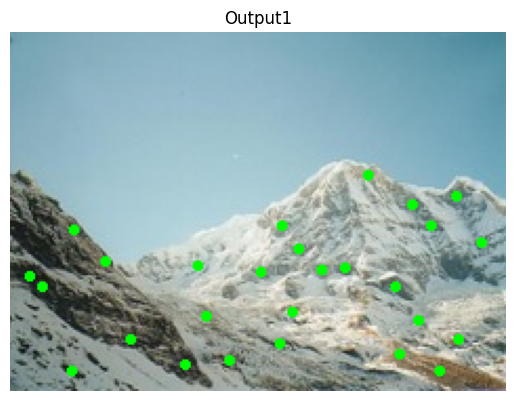

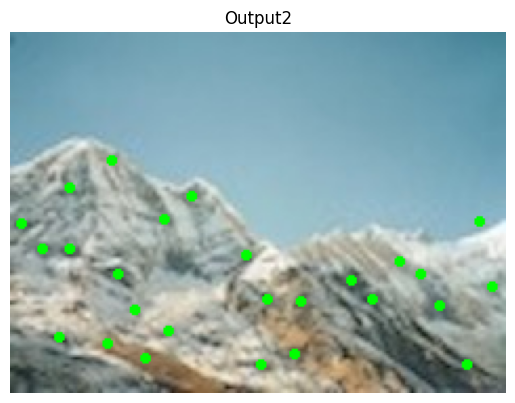

In [10]:
# 展示两张图像的特征点
plt.title('Output1')
plt.axis('off')
plt.imshow(img1_detect[:, :, ::-1])
plt.show()

plt.title('Output2')
plt.axis('off')
plt.imshow(img2_detect[:, :, ::-1])
plt.show()

接下来，需要将寻找出的特征点进行匹配

In [11]:
# 特征点匹配
def match_descriptors(descriptors1, descriptors2):

    max_index = np.zeros((len(descriptors1))) - 1
    # 初始化第一和第二近的特征点对数组
    maxmatch = np.zeros((len(descriptors1))) + 1e10
    secmatch = np.zeros((len(descriptors1))) + 1e10
    # 设定阈值
    threshold = 0.8

    for vec1_index in range(len(descriptors1)):
        for vec2_index in range(len(descriptors2)):
            # 计算特征点对的距离
            distance = np.linalg.norm(descriptors1[vec1_index] \
                                      - descriptors2[vec2_index])
            if distance < maxmatch[vec1_index]:
                # 更新当前最匹配的特征点
                maxmatch[vec1_index] = distance
                # 记录当前特征点对的距离
                max_index[vec1_index] = vec2_index
                
            elif distance < secmatch[vec1_index]:
                # 更新第二近特征点对的距离
                # 这里只需要更新距离即可，因为不关心哪一个点是第二近的
                secmatch[vec1_index] = distance

    matches = []
    # 返回匹配的特征点对的坐标信息
    for i in range(len(descriptors1)):
        if maxmatch[i] / secmatch[i] < threshold:
            matches.append((i, int(max_index[i])))

    return matches

In [12]:
def draw_matches(image1, image2, corners1, corners2, matches):
    # 获得两张图像的分辨率
    h1, w1 = image1.shape
    h2, w2 = image2.shape
    hres = 0
    if h1 >= h2:
        hres = int((h1 - h2) / 2)
    
        # 将两张图像拼接成高度一致的图像，方便进行特征点对的比对
        match_image = np.zeros((h1, w1 + w2, 3), np.uint8)

        # 对R、G、B图像分别处理
        for i in range(3):
            match_image[: h1, : w1, i] = image1
            match_image[hres: hres + h2, w1: w1 + w2, i] = image2

        for i in range(len(matches)):
            m = matches[i]
            # 获得匹配的特征点对在图中的坐标
            pt1 = (int(corners1[m[0]][0]), int(corners1[m[0]][1]))
            pt2 = (int(corners2[m[1]][0] + w1), 
                   int(corners2[m[1]][1] + hres))
            # 将其圈出
            cv2.circle(match_image, pt1, 1, (0,255,0), 2)
            cv2.circle(match_image, (pt2[0], pt2[1]), 1, (0,255,0), 2)
            # 画线相连
            cv2.line(match_image, pt1, pt2, (0, 0, 255))
    else:
        hres = int((h2 - h1) / 2)
        
         # 将两张图像拼接成高度一致的图像，方便进行特征点对的比对
        match_image = np.zeros((h2, w1 + w2, 3), np.uint8)

        # 对R、G、B图像分别处理
        for i in range(3):
            match_image[hres: hres + h1, : w1, i] = image1
            match_image[: h2, w1: w1 + w2, i] = image2

        for i in range(len(matches)):
            m = matches[i]
            # 获得匹配的特征点对在图中的坐标
            pt1 = (int(corners1[m[0]][0]), 
                   int(corners1[m[0]][1] + hres))
            pt2 = (int(corners2[m[1]][0] + w1), 
                   int(corners2[m[1]][1]))
            # 将其圈出
            cv2.circle(match_image, pt1, 1, (0,255,0), 2)
            cv2.circle(match_image, (pt2[0], pt2[1]), 1, (0,255,0), 2)
            # 画线相连
            cv2.line(match_image, pt1, pt2, (0, 0, 255))
        
    return match_image


(-0.5, 471.5, 171.5, -0.5)

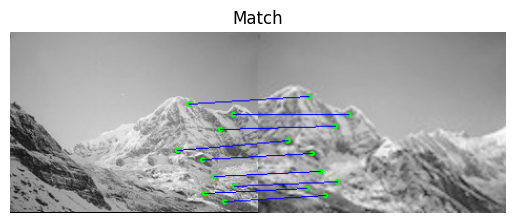

In [13]:
# 进行图像匹配
matches = match_descriptors(descriptors1, descriptors2)
image1 = cv2.imread('sift1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('sift2.png', cv2.IMREAD_GRAYSCALE)

# 绘制匹配连线
match_image = draw_matches(image1, image2, corners1, corners2, matches)

plt.title('Match')
plt.imshow(match_image)
plt.axis('off')


可以很明显的看出，两幅图像中相同的特征点完美的匹配在了一起。再这之后，便可以进行图像拼接等一系列后续操作了。